# Import libraries

In [1]:
import numpy as np
import random as rn
import os
from keras import backend as K
import  tensorflow.compat.v1  as tf
tf.disable_v2_behavior() 
import tensorflow as tf

#--------------------------------------------------------------------------------------------------------------------
# Reproducible
seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(seed)
#--------------------------------------------------------------------------------------------------------------------

import scipy.sparse as sp
import time
import pandas as pd
import sys

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sys.path.append(r"../../")

from dvgae_alpha_beta.evaluation import get_roc_score
from dvgae_alpha_beta.input_data import load_data, load_label
from dvgae_alpha_beta.model import *
from dvgae_alpha_beta.optimizer import *
from dvgae_alpha_beta.preprocessing import *

Instructions for updating:
non-resource variables are not supported in the long term


# Parameters setting

In [2]:
layers_no=6
data_path="../../Datasets/"
path_now="./log/"

dataset='citeseer'
model_name='DVGAE_alpha_beta_feature'

dropout=0.0
epochs=200
features_used=True
learning_rate=0.01
nb_run=1
prop_val=5
prop_test=10
validation=True
verbose=True

# Load data

In [3]:
adj_init, features_init = load_data(dataset,data_path)
num_adj=adj_init.shape[1]

# Training and testing

In [4]:
loss_coeff_adj=0.001
loss_coeff_AE=0.5
results_output_path = path_now+model_name+"/"
mkdir(results_output_path)

for seed_i in np.arange(nb_run):
    
    seed=seed_i
    lost_list=[]
    roc_list=[]
    ap_list=[]
    mean_time=[]
    
    adj, val_edges, val_edges_false, test_edges, test_edges_false =mask_test_edges(adj_init, seed,prop_test, prop_val)
                
    t_start = time.time()

    if features_used:
        features = features_init
    
    num_nodes = adj.shape[0]

    if not features_used:
        features = sp.identity(adj.shape[0])

    features = sparse_to_tuple(features)
    num_features = features[2][1]
    features_nonzero = features[1].shape[0]
        
    placeholders = {
        'features': tf.sparse_placeholder(tf.float32),
        'adj': tf.sparse_placeholder(tf.float32),
        'adj_orig': tf.sparse_placeholder(tf.float32),
        'dropout': tf.placeholder_with_default(0., shape = ())
    }

#--------------------------------------------------------------------------------------------------------------------
# Create model
    if model_name=='DVGAE_alpha_beta_feature':
        model = DVGAE_alpha_beta_feature(placeholders, layers_no,num_features, num_nodes,features_nonzero)
    elif model_name=='DVGAE_alpha_beta_no_feature':
        model=DVGAE_alpha_beta_no_feature(placeholders, layers_no,num_features, num_adj,num_nodes,features_nonzero)
    else:
        raise ValueError('Undefined model!')

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0]- adj.sum()) * 2)
    
    with tf.name_scope('optimizer'):
        if model_name in ('DVGAE_alpha_beta_feature'):
            opt =OptimizerVAE_FeatureReconstrution(preds_adj = model.reconstructions,\
                                                   preds_Features=model.feature_reconstruction,\
                                                   labels_adj = tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],\
                                                                                                     validate_indices = False), [-1]),\
                                                   labels_Features=placeholders['features'],\
                                                   labels_adj_rec=placeholders['adj'],\
                                                   loss_coeff_adj=loss_coeff_adj,\
                                                   loss_coeff_AE=loss_coeff_AE,\
                                                   model = model,\
                                                   num_nodes = num_nodes,\
                                                   pos_weight = pos_weight,\
                                                   norm = norm)
                
        elif model_name in ('DVGAE_alpha_beta_no_feature'):
            opt =OptimizerVAE_AdjReconstrution(preds_adj = model.reconstructions,\
                                               preds_adj_rec=model.adj_reconstruction,\
                                               labels_adj = tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                                                 validate_indices = False), [-1]),\
                                               labels_Features=placeholders['features'],\
                                               labels_adj_rec=placeholders['adj'],\
                                               loss_coeff_adj=loss_coeff_adj,\
                                               loss_coeff_AE=loss_coeff_AE,\
                                               model = model,\
                                               num_nodes = num_nodes,\
                                               pos_weight = pos_weight,\
                                               norm = norm)

    adj_norm = preprocess_graph(adj)
    adj_label = sparse_to_tuple(adj + sp.eye(adj.shape[0]))

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        t = time.time()
        feed_dict = construct_feed_dict(adj_norm, adj_label, features,placeholders)
        feed_dict.update({placeholders['dropout']: dropout})
        outs = sess.run([opt.opt_op, opt.cost, opt.accuracy],feed_dict = feed_dict)
        avg_cost = outs[1]
        if verbose:
            lost_list.append(avg_cost)
            print("Epoch:", '%04d' % (epoch + 1), "training loss=", "{:.5f}".format(avg_cost),"time=", "{:.5f}".format(time.time() - t))
                    
            if validation:
                feed_dict.update({placeholders['dropout']: 0})
                emb = sess.run(model.z_mean, feed_dict = feed_dict)
                feed_dict.update({placeholders['dropout']: dropout})
                val_roc, val_ap = get_roc_score(val_edges, val_edges_false, emb)
                roc_list.append(val_roc)
                ap_list.append(val_ap)
                print("validation roc=", "{:.5f}".format(val_roc), "validation ap=", "{:.5f}".format(val_ap))

    emb = sess.run(model.z_mean, feed_dict = feed_dict)   
    mean_time.append(time.time() - t_start)
    
    roc_score, ap_score = get_roc_score(test_edges, test_edges_false, emb)
    print("testing roc=", "{:.5f}".format(roc_score), "testing ap=", "{:.5f}".format(ap_score))
    
    roc_list.append(roc_score)
    ap_list.append(ap_score)
    
    mean_time_=np.array(mean_time)
    write_to_csv(mean_time_.reshape(1,len(mean_time_)),results_output_path+"layers_"+str(layers_no)+"_time.csv")

    roc_list_=np.array(roc_list)
    write_to_csv(roc_list_.reshape(1,len(roc_list_)),results_output_path+"layers_"+str(layers_no)+"_roc.csv")

    ap_list_=np.array(ap_list)
    write_to_csv(ap_list_.reshape(1,len(ap_list_)),results_output_path+"layers_"+str(layers_no)+"_ap.csv")

Successful!
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
targets is deprecated, use labels instead
Epoch: 0001 training loss= 0.00386 time= 2.23691
validation roc= 0.64546 validation ap= 0.66627
Epoch: 0002 training loss= 0.00360 time= 0.66271
validation roc= 0.64125 validation ap= 0.67341
Epoch: 0003 training loss= 0.00334 time= 0.51599
validation roc= 0.64866 validation ap= 0.68458
Epoch: 0004 training loss= 0.00316 time= 0.61854
validation roc= 0.65582 validation ap= 0.69578
Epoch: 0005 training loss= 0.00301 time= 0.54418
validation roc= 0.66609 validation ap= 0.70519
Epoch: 0006 training loss= 0.00291 time= 0.56257
validation roc= 0.68664 validation ap= 0.72415
Epoch: 0007 training loss= 0.00281 time= 0.51709
validation roc= 0.71946 validation ap= 0.75543
Epoch: 0008 training loss= 0.00276 time= 0.52666
validation roc= 0.75922 validation ap= 0.78683
Epoch: 0009 training loss= 0.00272 t

# Visulization

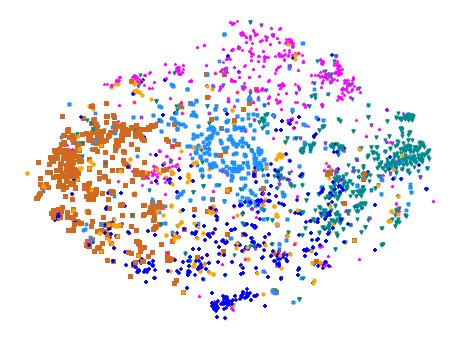

In [5]:
emb=emb
labels=load_label(dataset,data_path)

X_embedded = TSNE(n_components=2, init='pca', random_state=seed).fit_transform(emb)

cs=['orange','blue','darkcyan','fuchsia','chocolate','dodgerblue','aqua','green','red','purple']
markers=['o','+','v','2','s','X','d','>','*','<']

fig, ax = plt.subplots(1,figsize=(8,6))
for i in np.arange(X_embedded.shape[0]):
    scatter = ax.scatter(X_embedded[i,0],X_embedded[i,1],label=labels[i],marker=markers[labels[i]],color=cs[labels[i]], s=10, alpha = 1)
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.axis('off')
plt.show()